In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
# plt.style.use('fivethirtyeight')
import seaborn as sns
color_palette = sns.color_palette()

import glob
from collections import Counter
import plotly.express as px

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re
import spacy
import emoji
from imblearn.over_sampling import RandomOverSampler

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics, preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rsury\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rsury\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rsury\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
def f(i):
    return pd.read_csv(i, sep ='\t', header=None)

# **Train set - Processing**

In [3]:
train_path = glob.glob('./data/downloaded/*train-A.tsv')
train_df = pd.concat(map(f, train_path))
train_df = train_df.rename(columns={0:'id', 1:'sentiment', 2:'tweet'})
train_df.sentiment = train_df.sentiment.str.strip()
print(f'Size of train dataset : {train_df.shape}')
train_df.head()

Size of train dataset : (16173, 3)


,id,sentiment,tweet
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I’m going to Cha...
1,263405084770172928,negative,"Theo Walcott is still shit, watch Rafa and Joh..."
2,262163168678248449,negative,"its not that I’m a GSP fan, i just hate Nick D..."
3,264249301910310912,negative,Iranian general says Israel’s Iron Dome can’t ...
4,262682041215234048,neutral,"Tehran, Mon Amour: Obama Tried to Establish Ti..."


In [4]:
print(f' No. of duplicate values in train dataset : {train_df.duplicated().sum()}')

 No. of duplicate values in train dataset : 306


In [5]:
# train_df['sentiment'].replace('positive', 1,inplace=True)
# train_df['sentiment'].replace('negative', -1,inplace=True)
# train_df['sentiment'].replace('neutral', 0,inplace=True)
# train_df.head()

In [6]:
train_sentiment_cnt = train_df.groupby('sentiment').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
train_sentiment_cnt.style.background_gradient(cmap='Oranges')

,sentiment,tweet
2,positive,6904
1,neutral,6882
0,negative,2387


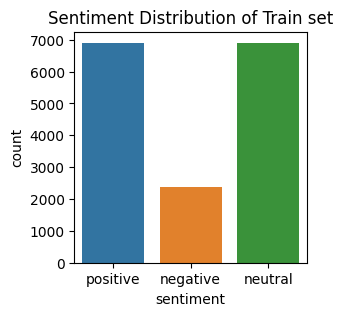

In [7]:
plt.figure(figsize=(3,3))
sns.countplot(x='sentiment',data=train_df).set_title('Sentiment Distribution of Train set')
plt.show()

In [8]:
train_df['temp_list'] = train_df['tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,12220
1,to,7407
2,on,4581
3,in,4544
4,a,4149
5,and,4091
6,I,3974
7,of,3748
8,for,3472
9,is,3092


In [9]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Train Dataset', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [10]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train_df['temp_list'] = train_df['temp_list'].apply(lambda x:remove_stopword(x))

In [11]:
top = Counter([item for sublist in train_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,may,1705
2,tomorrow,1489
3,going,1087
4,-,1076
5,The,993
6,see,850
7,1st,835
8,like,783
9,get,735
10,day,695


In [12]:
#MosT common positive words
Positive_sent = train_df[train_df['sentiment']=='positive']

top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,I,1884
1,tomorrow,703
2,may,651
3,see,503
4,going,452
5,-,409
6,day,394
7,The,369
8,1st,337
9,like,322


# **Dev set - Processing**

In [13]:
dev_path = glob.glob('./data/downloaded/*dev-A.tsv')
dev_df = pd.concat(map(f, dev_path))
dev_df = dev_df.rename(columns={0:'id', 1:'sentiment', 2:'tweet'})
dev_df.sentiment = dev_df.sentiment.str.strip()
print(f'Size of dev dataset : {dev_df.shape}')
dev_df.head()

Size of dev dataset : (3653, 3)


,id,sentiment,tweet
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is ...
1,263791921753882624,neutral,Some areas of New England could see the first ...
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up ...


In [14]:
# dev_df['sentiment'].replace('positive', 1,inplace=True)
# dev_df['sentiment'].replace('negative', -1,inplace=True)
# dev_df['sentiment'].replace('neutral', 0,inplace=True)
# dev_df.head()

In [15]:
print(f' No. of duplicate values in dev dataset : {dev_df.duplicated().sum()}')

 No. of duplicate values in dev dataset : 4


In [16]:
dev_sentiment_cnt = dev_df.groupby('sentiment').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
dev_sentiment_cnt.style.background_gradient(cmap='Oranges')

,sentiment,tweet
1,neutral,1504
2,positive,1418
0,negative,731


# **Test set - Processing**

In [17]:
test_path = glob.glob('./data/downloaded/*test-A.tsv')
test_df = pd.concat(map(f, test_path))
test_df = test_df.drop(columns=[3], axis=1) # because of timestamp at the end of twitter-2016test-A.tsv file, it show 4th column that is not need for our analysis
test_df = test_df.rename(columns={0:'id', 1:'sentiment', 2:'tweet'})
test_df.sentiment = test_df.sentiment.str.strip()
print(f'Size of test dataset : {test_df.shape}')
test_df.head()

Size of test dataset : (30422, 3)


,id,sentiment,tweet
0,264238274963451904,positive,"@jjuueellzz down in the Atlantic city, ventnor..."
1,218775148495515649,positive,Musical awareness: Great Big Beautiful Tomorro...
2,258965201766998017,neutral,On Radio786 100.4fm 7:10 Fri Oct 19 Labour ana...
3,262926411352903682,negative,"Kapan sih lo ngebuktiin,jan ngomong doang Susa..."
4,171874368908050432,neutral,"Excuse the connectivity of this live stream, f..."


In [18]:
# test_df['sentiment'].replace('positive', 1,inplace=True)
# test_df['sentiment'].replace('negative', -1,inplace=True)
# test_df['sentiment'].replace('neutral', 0,inplace=True)
# test_df.head()

In [19]:
print(f' No. of duplicate values in test dataset : {test_df.duplicated().sum()}')

 No. of duplicate values in test dataset : 66


In [20]:
test_sentiment_cnt = test_df.groupby('sentiment').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
test_sentiment_cnt.style.background_gradient(cmap='Oranges')

,sentiment,tweet
1,neutral,14192
2,positive,11548
0,negative,4682


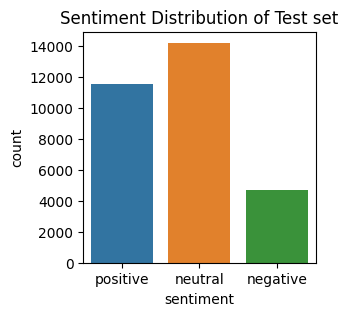

In [21]:
plt.figure(figsize=(3,3))
sns.countplot(x='sentiment',data=test_df).set_title('Sentiment Distribution of Test set')
plt.show()

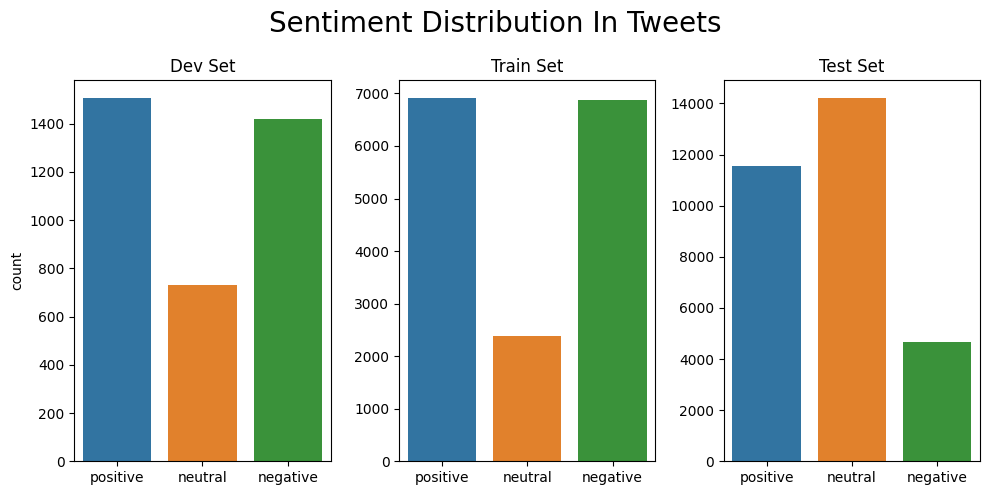

In [22]:
fig, ax = plt.subplots(1, 3, sharex='all', figsize=(10,5))
fig.suptitle('Sentiment Distribution In Tweets', fontsize=20)
sns.countplot(ax = ax[0], x='sentiment',data=dev_df)
ax[0].set(xlabel=None) 
ax[0].set_title('Dev Set')
sns.countplot(ax = ax[1], x='sentiment',data=train_df)
ax[1].set_title('Train Set')
ax[1].set(xlabel=None, ylabel=None) 
sns.countplot(ax = ax[2], x='sentiment',data=test_df)
ax[2].set_title('Test Set')
ax[2].set(xlabel=None, ylabel=None) 
plt.tight_layout()
plt.show()

In [23]:
train_df.drop(columns=['temp_list'], inplace=True)

# **DataSet Pre-Processing**

In [24]:
def decode_unicode_chars(tweets):
    tweets = tweets.str.encode('utf-8')
    return tweets.str.decode('unicode_escape')

In [25]:
# train_df.tweet = decode_unicode_chars(train_df.tweet)
# dev_df.tweet = decode_unicode_chars(dev_df.tweet)
# test_df.tweet = decode_unicode_chars(test_df.tweet)

In [26]:
def preprocess(tweets):
    # Lowercase the tweets
    tweets = [tweet.lower() for tweet in tweets]
    
    # Remove URLs, hashtags, and mentions
    tweets = [re.sub(r'(?:https?:\/\/)?(?:[\w]+\.)+[\w]+(?:\/[\w\d]+)?', '', tweet) for tweet in tweets]
    tweets = [re.sub(r'#\w+', '', tweet) for tweet in tweets]
    tweets = [re.sub(r'@\w+', '', tweet) for tweet in tweets]
    
    # Remove emojis
    tweets = [emoji.demojize(tweet) for tweet in tweets]
    
    # Remove punctuation and extra whitespace
    tweets = [re.sub(r'[^\w\s]', '', tweet) for tweet in tweets]
    tweets = [re.sub(r'\s+', ' ', tweet) for tweet in tweets]
    
    # Remove stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    tweets = [[word for word in tweet.split() if word not in stopwords] for tweet in tweets]
    
    # Lemmatize the words
    # nlp = spacy.load('en_core_web_sm')
    # tweets = [[nlp(word)[0].lemma_ for word in tweet] for tweet in tweets]
    lemmatizer = WordNetLemmatizer()
    tweets = [[lemmatizer.lemmatize(word) for word in tweet] for tweet in tweets]
    
    # Stem the words
    # stemmer = nltk.stem.SnowballStemmer('english')
    # tweets = [[stemmer.stem(word) for word in tweet] for tweet in tweets]
    
    # Join the words back into a single string
    tweets = [' '.join(tweet) for tweet in tweets]
    
    return tweets

In [27]:
train_df['processed_tweet'] = preprocess(train_df.tweet)
train_df.head()

,id,sentiment,tweet,processed_tweet
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I’m going to Cha...,gas house hit im going chapel hill sat
1,263405084770172928,negative,"Theo Walcott is still shit, watch Rafa and Joh...",theo walcott still shit watch rafa johnny deal...
2,262163168678248449,negative,"its not that I’m a GSP fan, i just hate Nick D...",im gsp fan hate nick diaz cant wait february
3,264249301910310912,negative,Iranian general says Israel’s Iron Dome can’t ...,iranian general say israel iron dome cant deal...
4,262682041215234048,neutral,"Tehran, Mon Amour: Obama Tried to Establish Ti...",tehran mon amour obama tried establish tie mul...


In [28]:
dev_df['processed_tweet'] = preprocess(dev_df.tweet)
dev_df.head()

,id,sentiment,tweet,processed_tweet
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is ...,match plusu002c tomorrow busy dayu002c awarene...
1,263791921753882624,neutral,Some areas of New England could see the first ...,area new england could see first flake season ...
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...,2nd worst qb definitely tony romo man like sha...
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...,washington u president barack obama vowed wedn...
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up ...,yu2019all hear tony romo dressed halloween gia...


In [29]:
test_df['processed_tweet'] = preprocess(test_df.tweet)
test_df.head()

,id,sentiment,tweet,processed_tweet
0,264238274963451904,positive,"@jjuueellzz down in the Atlantic city, ventnor...",atlantic city ventnor margate ocean city area ...
1,218775148495515649,positive,Musical awareness: Great Big Beautiful Tomorro...,musical awareness great big beautiful tomorrow...
2,258965201766998017,neutral,On Radio786 100.4fm 7:10 Fri Oct 19 Labour ana...,radio786 710 fri oct 19 labour analyst shawn h...
3,262926411352903682,negative,"Kapan sih lo ngebuktiin,jan ngomong doang Susa...",kapan sih lo ngebuktiinjan ngomong doang susah...
4,171874368908050432,neutral,"Excuse the connectivity of this live stream, f...",excuse connectivity live stream baba amr many ...


In [30]:
# train_df['sentiment'].replace('positive', 1,inplace=True)
# train_df['sentiment'].replace('negative', -1,inplace=True)
# train_df['sentiment'].replace('neutral', 0,inplace=True)
# train_df.head()

In [31]:
# https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(train_df['processed_tweet']).reshape(-1, 1), np.array(train_df['sentiment']).reshape(-1, 1));
train_ = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['processed_tweet', 'sentiment']);

In [32]:
X = train_['processed_tweet'].values
y = train_['sentiment'].values

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [34]:
X_test = test_df['processed_tweet'].values
y_test = test_df['sentiment'].values

# **Naive Bayes Model**

In [35]:
nb_model = Pipeline([
        ('vect', CountVectorizer()),
        ('tdidf', TfidfTransformer(use_idf=True)),
        ('clf', MultinomialNB()),
    ])
nb_model.fit(X_train, y_train)
pred_nb = nb_model.predict(X_test)

print(metrics.classification_report(y_test, pred_nb))

              precision    recall  f1-score   support

    negative       0.34      0.63      0.44      4682
     neutral       0.64      0.42      0.51     14192
    positive       0.58      0.64      0.61     11548

    accuracy                           0.53     30422
   macro avg       0.52      0.56      0.52     30422
weighted avg       0.57      0.53      0.53     30422



In [36]:
train_df.head()

,id,sentiment,tweet,processed_tweet
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I’m going to Cha...,gas house hit im going chapel hill sat
1,263405084770172928,negative,"Theo Walcott is still shit, watch Rafa and Joh...",theo walcott still shit watch rafa johnny deal...
2,262163168678248449,negative,"its not that I’m a GSP fan, i just hate Nick D...",im gsp fan hate nick diaz cant wait february
3,264249301910310912,negative,Iranian general says Israel’s Iron Dome can’t ...,iranian general say israel iron dome cant deal...
4,262682041215234048,neutral,"Tehran, Mon Amour: Obama Tried to Establish Ti...",tehran mon amour obama tried establish tie mul...


In [ ]:
from transformers import BertTokenizer,BertForSequenceClassification,AdamW
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)

In [ ]:
train_df['sentiment'].replace('positive', 2,inplace=True)
train_df['sentiment'].replace('negative', 0,inplace=True)
train_df['sentiment'].replace('neutral', 1,inplace=True)
train_df.head()

,id,sentiment,tweet,processed_tweet
0,264183816548130816,2,Gas by my house hit $3.39!!!! I’m going to Cha...,gas hous hit im go chapel hill sat
1,263405084770172928,0,"Theo Walcott is still shit, watch Rafa and Joh...",theo walcott still shit watch rafa johnni deal...
2,262163168678248449,0,"its not that I’m a GSP fan, i just hate Nick D...",im gsp fan hate nick diaz cant wait februari
3,264249301910310912,0,Iranian general says Israel’s Iron Dome can’t ...,iranian general say israel iron dome cant deal...
4,262682041215234048,1,"Tehran, Mon Amour: Obama Tried to Establish Ti...",tehran mon amour obama tri establish tie mulla...


In [ ]:
labels = train_df.sentiment.values
text = train_df.processed_tweet.values

input_ids = []
attention_mask = []
for i in text:
    encoded_data = tokenizer.encode_plus(
    i,
    add_special_tokens=True,
    max_length=64,
    pad_to_max_length = True,
    return_attention_mask= True,
    return_tensors='pt')
    input_ids.append(encoded_data['input_ids'])
    attention_mask.append(encoded_data['attention_mask'])


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:2336: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [ ]:
input_ids = torch.cat(input_ids,dim=0)
attention_mask = torch.cat(attention_mask,dim=0)
labels = torch.tensor(labels)

In [ ]:
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler,TensorDataset,random_split

In [ ]:
dataset = TensorDataset(input_ids,attention_mask,labels)
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

print('Training Size - ',train_size)
print('Validation Size - ',val_size)

Training Size -  12832
Validation Size -  3209


In [ ]:
train_dl = DataLoader(train_dataset,sampler = RandomSampler(train_dataset), batch_size = 32)
val_dl = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset), batch_size = 32)

In [ ]:
len(train_dl),len(val_dl)

(401, 101)

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                      num_labels = 3, 
                                                      output_attentions = False, 
                                                      output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cpu


In [ ]:
optimizer = AdamW(model.parameters(),lr = 2e-5,eps=1e-8)

In [ ]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

In [ ]:
from transformers import get_linear_schedule_with_warmup
epochs = 1
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

In [ ]:
def evaluate(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [ ]:
from tqdm.notebook import tqdm
torch.cuda.empty_cache()
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

In [ ]:
loss_train_avg = loss_train_total/len(train_dl)
print(f'Training loss: {loss_train_avg}')

val_loss, predictions, true_vals = evaluate(val_dl)
val_acc = accuracy(predictions, true_vals)
print(f'Validation loss: {val_loss}')
print(f'Accuracy: {val_acc}')

Training loss: 0.8531383151128108
Validation loss: 0.7736828521926804
Accuracy: 0.649111872857588


# **RoBERTa**

In [2]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
model.type

<bound method Module.type of RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bia

In [38]:
label_list = []

for i in test_df.processed_tweet:
  text = i
  #text = preprocess(text)
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)

  label = np.argmax(scores, axis=0)
  label_list.append(label)

In [40]:
labels = train_["sentiment"].replace(['negative', 'neutral','positive'],
                        [0, 1, 2], inplace=False)
labels_test = test_df["sentiment"].replace(['negative', 'neutral','positive'],
                        [0, 1, 2], inplace=False)

In [41]:
print(metrics.classification_report(np.array(labels_test), label_list))


              precision    recall  f1-score   support

           0       0.61      0.63      0.62      4682
           1       0.64      0.82      0.72     14192
           2       0.84      0.54      0.66     11548

    accuracy                           0.68     30422
   macro avg       0.70      0.66      0.66     30422
weighted avg       0.71      0.68      0.68     30422

